In [1]:
import sys
print(sys.version)

3.9.6 (default, Aug 18 2021, 11:08:34) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)]


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from conditionalconformal import CondConf
import random
from scipy.spatial import ConvexHull

''' import functions from different modules '''
from split_table import split
from conformal_auxiliary import phi_fn
from real_data_exp import repeated_exp, get_CI, diff_N
from Myerson_auction import myerson_reserve

In [4]:
'''
Process raw eBay data
'''

# Read the eBay data CSV file
Table_palm7 = pd.read_csv("Palm+7-day+149auctions+Curve+Clustering.csv")

# Filter the data focusing on three main sellers
Table = Table_palm7[(Table_palm7['Seller'] == "syschannel") | (Table_palm7['Seller'] == "michael-33") | (Table_palm7['Seller'] == "saveking")]

# In each auction, only use each bidder's highest bid 
false = pd.Series([False] * len(Table), index=Table.index)
for j in Table['Auction ID'].unique():
    for i in Table[Table['Auction ID'] == j]['Bidder'].unique():
        max_bid = Table[(Table['Auction ID'] == j) & (Table['Bidder'] == i)]['BidAmount'].max()
        false |= ((Table['Auction ID'] == j) & (Table['Bidder'] == i) & (Table['BidAmount'] == max_bid))
Table_new = Table[false]

# Calculate the average historical bid for each bidder
Table_new = Table_new.copy()
Table_new['mean_bid'] = 0
for bidder in Table_new['Bidder'].unique():
    mean_bid = Table_new.loc[Table_new['Bidder'] == bidder, 'BidAmount'].mean()
    Table_new.loc[Table_new['Bidder'] == bidder, 'mean_bid'] = mean_bid

# Exclude the winning bid in each auction
Table_new['Rank'] = Table_new.groupby('Auction ID')['BidAmount'].rank(method='dense', ascending=False)
Table_new = Table_new[Table_new['Rank'] > 1].drop(columns=['Rank'])

In [5]:
'''
Calculate the average number of bidders for each auction
'''

average_bidders = 0
for auction_id in Table_new['Auction ID'].unique():
    average_bidders += len(Table_new[Table_new['Auction ID'] == auction_id])
average_bidders /= len(Table_new['Auction ID'].unique())

print(f"Average bidders: {average_bidders}")

Average bidders: 12.318181818181818


In [6]:
'''
Split the data: treat each specific auction as a new auction and the remaining data as historical data
'''

# Get unique Auction.ID for each Seller
Seller_syschannel = Table_new[Table_new['Seller'] == "syschannel"]['Auction ID'].unique()
Seller_michael = Table_new[Table_new['Seller'] == "michael-33"]['Auction ID'].unique()
Seller_saveking = Table_new[Table_new['Seller'] == "saveking"]['Auction ID'].unique()

# Create a list of DataFrames to specify the new auctions and historical data. The new auctions are classified into three types of item based on their features.
Table_his_syschannel = []
Table_new_syschannel = []
for i in Seller_syschannel:
    Table_his_syschannel.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_syschannel.append(Table_new[Table_new['Auction ID'] == i])
    
Table_his_michael = []
Table_new_michael = []
for i in Seller_michael:
    Table_his_michael.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_michael.append(Table_new[Table_new['Auction ID'] == i])

Table_his_saveking = []
Table_new_saveking = []
for i in Seller_saveking:
    Table_his_saveking.append(Table_new[Table_new['Auction ID'] != i])
    Table_new_saveking.append(Table_new[Table_new['Auction ID'] == i])

#### 1. Conduct 1000 experiments on the first type of item using different number of data points:

In [9]:
random.seed(1)
np.random.seed(1)

N_values = [150,300,500,700]

COAD_averages = []
COAD_CIs = []
myerson_revenue_averages = []
myerson_revenue_CIs = []
second_price_averages = []
coverage_IRs = []
reserve_prices = []

''' For each number of data points, run the experiments 1000 times '''
for N in N_values:
    Table_his = Table_his_syschannel 
    Table_new = Table_new_syschannel
    item = "syschannel"
    num_runs = 1000
    indices= [0, 1, 2, 14, 15, 17, 21, 25, 27] 
    COAD_average, COAD_CI, myerson_revenue_average, myerson_revenue_CI, second_price_average, _, coverage_IR, reserve_price = diff_N(Table_his, Table_new,N,item,num_runs, indices)
    # Obtain the average revenue of COAD and the corresponding error bars
    COAD_averages.append(COAD_average)
    COAD_CIs.append(COAD_CI)
    # Obtain the average revenue of the empirical Myerson auction and the corresponding error bars
    myerson_revenue_averages.append(myerson_revenue_average)
    myerson_revenue_CIs.append(myerson_revenue_CI)
    # Obtain the average revenue of the second price auction
    second_price_averages.append(second_price_average)
    # Obtain the vectors of the coverage probability
    coverage_IRs.append(coverage_IR)
    # Obtain the vectors of the single reserve price of the empirical Myerson auction
    reserve_prices.append(reserve_price)

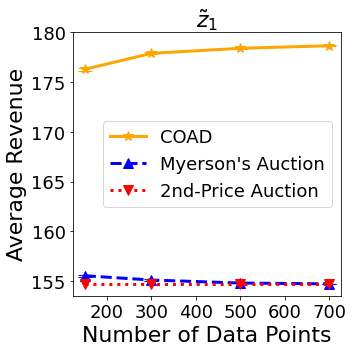

In [10]:
''' Draw the figure of the average revenue of different auction mechanisms under different number of data points, and add the error bars '''

COAD_CIs = [(x[1]-x[0])/2 for x in COAD_CIs]
myerson_revenue_CIs = [(x[1]-x[0])/2 for x in myerson_revenue_CIs]

plt.figure(figsize=(5, 5))

plt.plot(N_values, COAD_averages, label="COAD", color='orange', linewidth=3, marker='*', markersize=10)
plt.plot(N_values, myerson_revenue_averages, label="Myerson's Auction", color='blue', linestyle='--', linewidth=3, marker='^', markersize=10)
plt.errorbar(N_values, COAD_averages, yerr=COAD_CIs, fmt='none', ecolor='orange', capsize=7, elinewidth=2)
plt.errorbar(N_values, myerson_revenue_averages, yerr=myerson_revenue_CIs, fmt='none', ecolor='blue', capsize=7, elinewidth=2)
plt.plot(N_values, second_price_averages, label="2nd-Price Auction", color='red', linestyle=':', linewidth=3, marker='v', markersize=10)

plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel("Average Revenue", fontsize=22)
plt.title(r"$\tilde{z}_1$", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks([155,160,165,170,175,180], fontsize=18)
plt.legend(fontsize=18)
plt.grid(False)

plt.tight_layout()
plt.show()

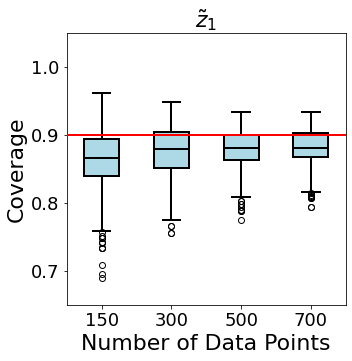

In [11]:
''' Draw the boxplots of the coverage probability for the true value, using different numbers of data points '''

fig = plt.figure(figsize=(5, 5))
plt.boxplot(coverage_IRs, patch_artist=True, 
            medianprops=dict(color="black", linewidth=2),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  
plt.title(r"$\tilde{z}_1$", fontsize=22)
plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel('Coverage', fontsize=22)
plt.locator_params(axis='y', nbins=5)  
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=18)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=18) 
plt.ylim([0.65, 1.05]) 
plt.show()

#### 2. Conduct 1000 experiments on the second type of item using different number of data points:

In [12]:
random.seed(1)
np.random.seed(1)

N_values = [150,300,500,700]

COAD_averages = []
COAD_CIs = []
myerson_revenue_averages = []
myerson_revenue_CIs = []
second_price_averages = []
coverage_IRs = []
reserve_prices = []

''' For each number of data points, run the experiments 1000 times '''
for N in N_values:
    Table_his = Table_his_michael
    Table_new = Table_new_michael
    item = "michael-33"
    num_runs = 1000
    indices= [2, 7, 13, 14, 15]
    COAD_average, COAD_CI, myerson_revenue_average, myerson_revenue_CI, second_price_average, _, coverage_IR, reserve_price = diff_N(Table_his, Table_new,N,item,num_runs, indices)
    # Obtain the average revenue of COAD and the corresponding error bars
    COAD_averages.append(COAD_average)
    COAD_CIs.append(COAD_CI)
    # Obtain the average revenue of the empirical Myerson auction and the corresponding error bars
    myerson_revenue_averages.append(myerson_revenue_average)
    myerson_revenue_CIs.append(myerson_revenue_CI)
    # Obtain the average revenue of the second price auction
    second_price_averages.append(second_price_average)
    # Obtain the vectors of the coverage probability
    coverage_IRs.append(coverage_IR)
    # Obtain the vectors of the single reserve price of the empirical Myerson auction
    reserve_prices.append(reserve_price)

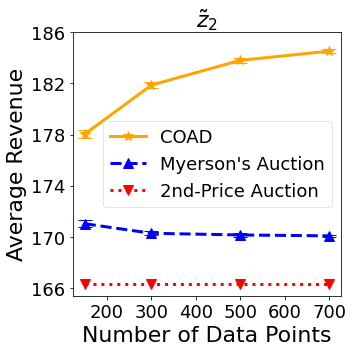

In [13]:
''' Draw the figure of the average revenue of different auction mechanisms under different number of data points, and add the error bars '''

COAD_CIs = [(x[1]-x[0])/2 for x in COAD_CIs]
myerson_revenue_CIs = [(x[1]-x[0])/2 for x in myerson_revenue_CIs]

plt.figure(figsize=(5, 5))

plt.plot(N_values, COAD_averages, label="COAD", color='orange', linewidth=3, marker='*', markersize=10)
plt.plot(N_values, myerson_revenue_averages, label="Myerson's Auction", color='blue', linestyle='--', linewidth=3, marker='^', markersize=10)
plt.errorbar(N_values, COAD_averages, yerr=COAD_CIs, fmt='none', ecolor='orange', capsize=7, elinewidth=2)
plt.errorbar(N_values, myerson_revenue_averages, yerr=myerson_revenue_CIs, fmt='none', ecolor='blue', capsize=7, elinewidth=2)
    
plt.plot(N_values, second_price_averages, label="2nd-Price Auction", color='red', linestyle=':', linewidth=3, marker='v', markersize=10)

plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel("Average Revenue", fontsize=22)
plt.title(r"$\tilde{z}_2$", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks([166,170,174,178,182,186], fontsize=18)
plt.legend(fontsize=18,framealpha=0.5)
plt.grid(False)

plt.tight_layout()
plt.show()

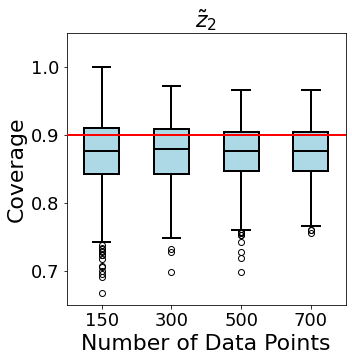

In [14]:
''' Draw the boxplots of the coverage probability for the true value, using different numbers of data points '''

fig = plt.figure(figsize=(5, 5))
plt.boxplot(coverage_IRs, patch_artist=True, 
            medianprops=dict(color="black", linewidth=2),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  
plt.title(r"$\tilde{z}_2$", fontsize=22)
plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel('Coverage', fontsize=22)
plt.locator_params(axis='y', nbins=5)  
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)
plt.ylim([0.65, 1.05])
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=18)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=18)  # Correct way
plt.show()

#### 3. Conduct 1000 experiments on the third type of item using different number of data points:

In [15]:
random.seed(123)
np.random.seed(123)

N_values = [150,300,500,700]

COAD_averages = []
COAD_CIs = []
myerson_revenue_averages = []
myerson_revenue_CIs = []
second_price_averages = []
coverage_IRs = []
reserve_prices = []

''' For each number of data points, run the experiments 1000 times '''
for N in N_values:
    Table_his = Table_his_saveking
    Table_new = Table_new_saveking
    item = "saveking"
    num_runs = 1000
    indices= [1,8,9]
    COAD_average, COAD_CI, myerson_revenue_average, myerson_revenue_CI, second_price_average, _, coverage_IR, reserve_price = diff_N(Table_his, Table_new,N,item,num_runs, indices)
    # Obtain the average revenue of COAD and the corresponding error bars
    COAD_averages.append(COAD_average)
    COAD_CIs.append(COAD_CI)
    # Obtain the average revenue of the empirical Myerson auction and the corresponding error bars
    myerson_revenue_averages.append(myerson_revenue_average)
    myerson_revenue_CIs.append(myerson_revenue_CI)
    # Obtain the average revenue of the second price auction
    second_price_averages.append(second_price_average)
    # Obtain the vectors of the coverage probability
    coverage_IRs.append(coverage_IR)
    # Obtain the vectors of the single reserve price of the empirical Myerson auction
    reserve_prices.append(reserve_price)

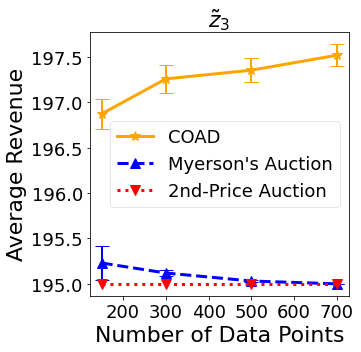

In [16]:
''' Draw the figure of the average revenue of different auction mechanisms under different number of data points, and add the error bars '''

COAD_CIs = [(x[1]-x[0])/2 for x in COAD_CIs]
myerson_revenue_CIs = [(x[1]-x[0])/2 for x in myerson_revenue_CIs]

plt.figure(figsize=(5.1, 5))

plt.plot(N_values, COAD_averages, label="COAD", color='orange', linewidth=3, marker='*', markersize=10)
plt.plot(N_values, myerson_revenue_averages, label="Myerson's Auction", color='blue', linestyle='--', linewidth=3, marker='^', markersize=10)
plt.errorbar(N_values, COAD_averages, yerr=COAD_CIs, fmt='none', ecolor='orange', capsize=7, elinewidth=2)
plt.errorbar(N_values, myerson_revenue_averages, yerr=myerson_revenue_CIs, fmt='none', ecolor='blue', capsize=7, elinewidth=2)

plt.plot(N_values, second_price_averages, label="2nd-Price Auction", color='red', linestyle=':', linewidth=3, marker='v', markersize=10)

plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel("Average Revenue", fontsize=22)
plt.title(r"$\tilde{z}_3$", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks( fontsize=18)
plt.legend(fontsize=18,framealpha=0.5)
plt.grid(False)

plt.tight_layout()
plt.show()


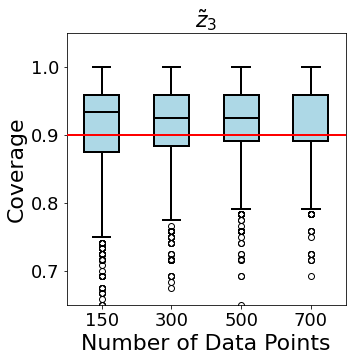

In [17]:
''' Draw the boxplots of the coverage probability for the true value, using different numbers of data points '''

fig = plt.figure(figsize=(5, 5))
plt.boxplot(coverage_IRs, patch_artist=True, 
            medianprops=dict(color="black", linewidth=2,zorder=4),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  
plt.title(r"$\tilde{z}_3$", fontsize=22)
plt.xlabel("Number of Data Points", fontsize=22)
plt.ylabel('Coverage', fontsize=22)
plt.locator_params(axis='y', nbins=5)  
plt.ylim([0.65, 1.05])
plt.yticks([0.7, 0.8, 0.9, 1.0], fontsize=18)
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=18)
plt.show()